In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path

import pandas as pd
from pyproj import CRS, Transformer
import rasterio
from rasterio.crs import CRS as CRS_rio
from rasterio.transform import Affine

In [15]:
# ----------------------------
# CONFIGURACIÓN GENERAL
# ----------------------------
BASE_DIR = Path("/content") if Path("/content").exists() else Path(".")
OUTDIR = BASE_DIR / "salidas_fold"
OUTDIR.mkdir(parents=True, exist_ok=True)

# Evitar warnings de fuentes
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# Elige modo de operación:
MODE = "design"   # "design" (A) o "csv" (B)

# --- Parámetros geodésicos comunes para exportes ---
# Define un ORIGEN geográfico (lat/lon) y el CRS UTM de salida (auto según origen).
# En modo CSV, la zona UTM se inferirá a partir del promedio lon/lat de tus puntos si vienen en WGS84;
# o puedes fijar EPSG manualmente.
lat0 = 4.3000
lon0 = -72.0800

def utm_epsg_from_lonlat(lon, lat):
    zone = int((lon + 180) // 6) + 1
    return (32600 if lat >= 0 else 32700) + zone


In [16]:
# ----------------------------
# MODO A: PARÁMETROS DE DISEÑO
# ----------------------------
# Geometría del survey (metros en plano "diseño")
length_m = 14500.0     # inline (eje y)
width_m  = 7200.0      # crossline (eje x)

# Geofísica
v   = 2300.0   # m/s
fmax = 90.0    # Hz
buz  = 10.0    # grados

# Profundidades
Zsl   = 500.0
Zob   = 2500.0
Zdeep = Zob

# Patch
n_half = 8

# Restricción de offset
Xmax = Zdeep


In [17]:
# ----------------------------
# MODO B: ARCHIVOS CSV REALES
# ----------------------------
# Estructura esperada:
# receivers.csv y sources.csv deben tener al menos:
#  - O bien columnas: id, lon, lat    (WGS84 EPSG:4326)
#  - O bien columnas: id, E, N        (UTM o proyectado; especifica EPSG abajo)
#
# Si usas E/N, especifica el EPSG de entrada:
INPUT_EPSG_FOR_EN = None  # p.ej. 3116 (MAGNA-SIRGAS) o 32618; None si lon/lat
RECEIVERS_CSV = BASE_DIR / "receivers_campo.csv"
SOURCES_CSV   = BASE_DIR / "sources_campo.csv"


In [18]:
# ----------------------------
# UTILIDADES
# ----------------------------
def make_receiver_grid(length_m, width_m, RI, RLI):
    n_rlines = int(np.floor(width_m / RLI)) + 1
    n_rperline = int(np.floor(length_m / RI)) + 1
    x_rlines = np.arange(n_rlines) * RLI
    y_r = np.arange(n_rperline) * RI
    XX = np.repeat(x_rlines, n_rperline)
    YY = np.tile(y_r, n_rlines)
    rec = np.column_stack([XX, YY])  # (x, y)
    ids = np.array([f"R_{k}_{i}" for k in range(n_rlines) for i in range(n_rperline)])
    return rec, ids

def make_source_grid(length_m, width_m, SI, SLI):
    n_slines = int(np.floor(length_m / SLI)) + 1
    n_sperline = int(np.floor(width_m / SI)) + 1
    y_slines = np.arange(n_slines) * SLI
    x_s = np.arange(n_sperline) * SI
    XX = np.tile(x_s, n_slines)
    YY = np.repeat(y_slines, n_sperline)
    src = np.column_stack([XX, YY])  # (x, y)
    ids = np.array([f"S_{j}_{l}" for j in range(n_slines) for l in range(n_sperline)])
    return src, ids

def compute_midpoints_pairs(rec_xy, src_xy, Xmax):
    """
    Empareja cada fuente con TODOS los receptores dentro de Xmax (distancia Euclídea)
    y devuelve midpoints (x,y) y pares (i_rec, i_src).
    *Sin* asumir líneas rectas ni grillas (sirve para MODO B).
    Complejidad O(Nsrc*Nrec), suficiente para tamaños moderados.
    Para >50k puntos, considera usar scipy.spatial.cKDTree.
    """
    mids = []
    pairs = []
    for s_idx in range(src_xy.shape[0]):
        dx = rec_xy[:,0] - src_xy[s_idx,0]
        dy = rec_xy[:,1] - src_xy[s_idx,1]
        dist = np.hypot(dx, dy)
        m = (dist <= Xmax)
        if np.any(m):
            rr = rec_xy[m]
            mids.append(0.5 * (rr + src_xy[s_idx]))
            rec_idx = np.where(m)[0]
            pairs += [(int(r), int(s_idx)) for r in rec_idx.tolist()]
    if not mids:
        return np.empty((0,2)), []
    return np.vstack(mids), pairs

def fold_from_midpoints(mid_xy, bin_x, bin_y, x0=None, y0=None, nx=None, ny=None):
    """
    Genera raster de fold en un grid E/N (o x/y) con celdas bin_x x bin_y.
    Si x0, y0, nx, ny son None, se auto-calcula el bounding box para cubrir todos los midpoints.
    Devuelve: fold array (ny, nx), origen (x0,y0), nx, ny
    """
    if mid_xy.shape[0] == 0:
        return np.zeros((1,1), dtype=np.int32), 0.0, 0.0, 1, 1

    if x0 is None or y0 is None or nx is None or ny is None:
        xmin, ymin = mid_xy.min(axis=0)
        xmax, ymax = mid_xy.max(axis=0)
        x0 = xmin
        y0 = ymin
        nx = int(np.ceil((xmax - x0) / bin_x)) + 1
        ny = int(np.ceil((ymax - y0) / bin_y)) + 1

    i = np.floor((mid_xy[:,0] - x0) / bin_x).astype(int)
    j = np.floor((mid_xy[:,1] - y0) / bin_y).astype(int)
    valid = (i >= 0) & (i < nx) & (j >= 0) & (j < ny)

    fold = np.zeros((ny, nx), dtype=np.int32)
    for ii, jj in zip(i[valid], j[valid]):
        fold[jj, ii] += 1
    return fold, x0, y0, nx, ny

def fold_stats(fold):
    vals = fold.ravel()
    covered = vals > 0
    if not covered.any():
        return {"min":0,"max":0,"mean":0.0,"median":0.0,"p10":0.0,"p50":0.0,"p90":0.0,"mode":0,"coverage_ratio":0.0}
    c = Counter(vals[covered].tolist())
    return {
        "min": int(vals[covered].min()),
        "max": int(vals[covered].max()),
        "mean": float(vals[covered].mean()),
        "median": float(np.median(vals[covered])),
        "p10": float(np.percentile(vals[covered], 10)),
        "p50": float(np.percentile(vals[covered], 50)),
        "p90": float(np.percentile(vals[covered], 90)),
        "mode": int(c.most_common(1)[0][0]),
        "coverage_ratio": float(covered.mean())
    }

def write_geotiff_fold(fold, x0, y0, bin_x, bin_y, epsg, path_tif):
    """
    Escribe un GeoTIFF con ejes alineados a E/N (sin rotación).
    (fila 0 = norte). Para esto, volteamos verticalmente el array.
    """
    fold_gdal = np.flipud(fold).astype(np.float32)
    # Esquina superior-izquierda del raster:
    # Nuestra malla tiene origen inferior-izquierdo (x0,y0). La esquina NW está en (x0, y0 + ny*bin_y)
    ny, nx = fold.shape
    c = x0
    f = y0 + ny * bin_y
    a = bin_x; d = 0.0
    b = 0.0;   e = -bin_y  # píxeles hacia abajo = decrece N
    transform = Affine(a, b, c, d, e, f)
    with rasterio.open(
        path_tif,
        "w",
        driver="GTiff",
        height=ny,
        width=nx,
        count=1,
        dtype=fold_gdal.dtype,
        crs=CRS_rio.from_epsg(epsg),
        transform=transform,
        nodata=0.0,
        compress="lzw"
    ) as dst:
        dst.write(fold_gdal, 1)

def plot_outputs(fold, title_prefix, outdir_png):
    # Heatmap
    plt.figure(figsize=(8,6))
    plt.imshow(fold, origin="lower", aspect="auto")
    plt.xlabel("Cols")
    plt.ylabel("Rows")
    plt.title(f"{title_prefix} - Fold heatmap")
    plt.colorbar(label="Fold")
    plt.savefig(outdir_png/"fold_map.png", dpi=200, bbox_inches="tight")
    plt.show()

    # Histograma
    vals = fold[fold>0].ravel()
    plt.figure(figsize=(7,5))
    if vals.size>0:
        plt.hist(vals, bins=40)
    plt.xlabel("Fold")
    plt.ylabel("Frecuencia de bins")
    plt.title(f"{title_prefix} - Distribución de Fold")
    plt.savefig(outdir_png/"fold_hist.png", dpi=200, bbox_inches="tight")
    plt.show()

    # Cobertura acumulada
    plt.figure(figsize=(7,5))
    if vals.size>0:
        s = np.sort(vals)
        thr = np.unique(s)
        frac = [np.mean(s >= t) for t in thr]
        plt.plot(thr, frac)
    plt.xlabel("Umbral de Fold")
    plt.ylabel("Fracción de bins (≥ umbral)")
    plt.title(f"{title_prefix} - Cobertura acumulada")
    plt.savefig(outdir_png/"fold_coverage_curve.png", dpi=200, bbox_inches="tight")
    plt.show()


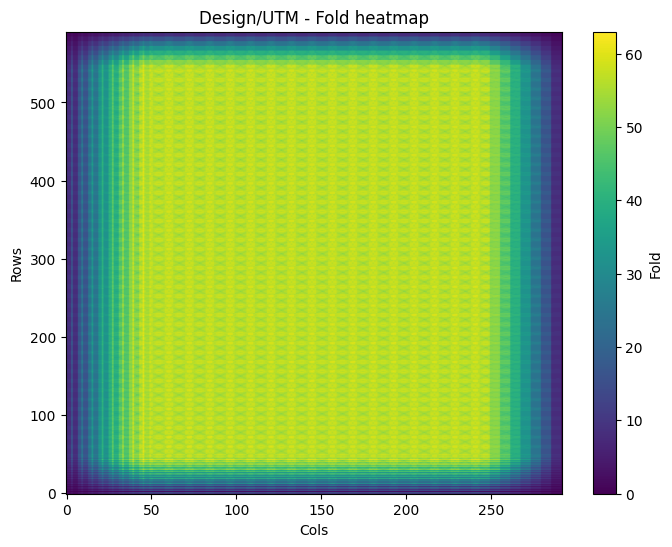

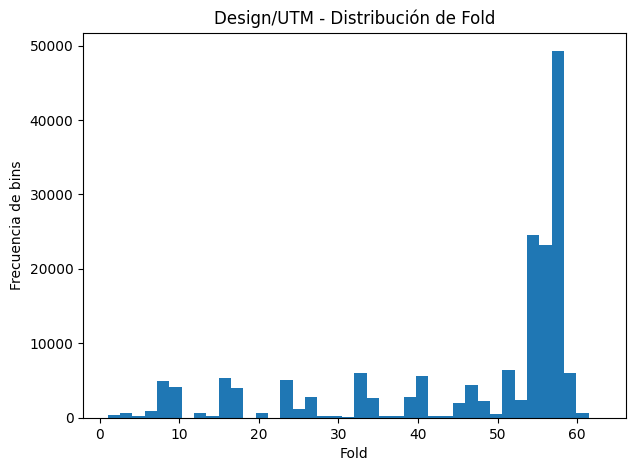

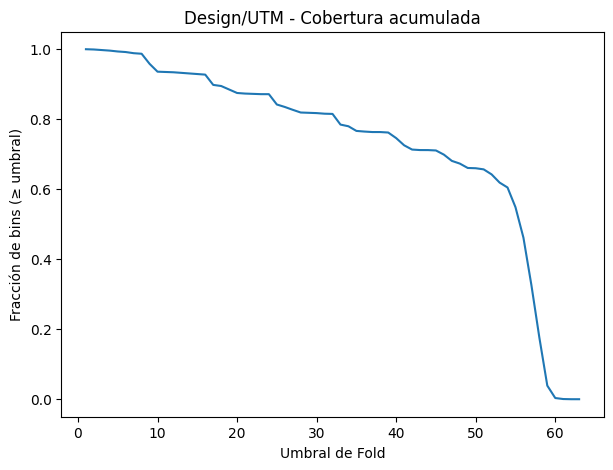

Listo (Modo A). Archivos en: /Users/lauraperez/Documents/Sismologia/Sismologia_Sismica/SismicaGIT/Taller1/salidas_fold


In [19]:
# ----------------------------
# EJECUCIÓN
# ----------------------------
if MODE == "design":
    # Cálculos sísmicos base
    RI = v / (3.0 * fmax * math.sin(math.radians(buz)))
    SI = RI
    bin_inline = RI / 2.0
    bin_xline  = SI / 2.0
    CMP_Bin    = bin_inline * bin_xline
    near_offset = Zsl / 1.2
    RLI = near_offset / math.sqrt(2.0)
    SLI = RLI

    # Grillas sintéticas en plano “diseño” (x=crossline, y=inline)
    rec_xy, rec_ids = make_receiver_grid(length_m, width_m, RI, RLI)
    src_xy, src_ids = make_source_grid(length_m, width_m, SI, SLI)

    # Exportar CSV de estaciones/disparos en WGS84 y UTM
    epsg_out = utm_epsg_from_lonlat(lon0, lat0)
    to_utm = Transformer.from_crs(4326, epsg_out, always_xy=True)
    # Para convertir del plano "diseño" a UTM, definimos origen en (lon0,lat0) y sin rotación (azimut=0)
    # Si tu inline real no es norte, puedes rotar; para simplicidad, lo dejamos axis-aligned:
    E0, N0 = to_utm.transform(lon0, lat0)
    # Mapear (x,y) diseño → UTM: E = E0 + x ; N = N0 + y
    rec_E = E0 + rec_xy[:,0]; rec_N = N0 + rec_xy[:,1]
    src_E = E0 + src_xy[:,0]; src_N = N0 + src_xy[:,1]
    to_ll = Transformer.from_crs(epsg_out, 4326, always_xy=True)
    rec_lon, rec_lat = to_ll.transform(rec_E, rec_N)
    src_lon, src_lat = to_ll.transform(src_E, src_N)

    df_rec = pd.DataFrame({"id":rec_ids, "x_survey":rec_xy[:,0], "y_survey":rec_xy[:,1],
                           "E":rec_E, "N":rec_N, "lon":rec_lon, "lat":rec_lat})
    df_src = pd.DataFrame({"id":src_ids, "x_survey":src_xy[:,0], "y_survey":src_xy[:,1],
                           "E":src_E, "N":src_N, "lon":src_lon, "lat":src_lat})
    df_rec.to_csv(OUTDIR/"receivers_design.csv", index=False)
    df_src.to_csv(OUTDIR/"sources_design.csv", index=False)

    # Midpoints en plano diseño, restringidos por Xmax (solo por física; sin patch adicional)
    mid_xy, pairs = compute_midpoints_pairs(rec_xy, src_xy, Xmax)

    # Para GIS, creamos raster de fold en UTM (E/N), usando el mismo tamaño de bin en metros
    mid_E = E0 + mid_xy[:,0]; mid_N = N0 + mid_xy[:,1]
    mid_EN = np.column_stack([mid_E, mid_N])

    fold, x0, y0, nx, ny = fold_from_midpoints(mid_EN, bin_xline, bin_inline)
    stats = fold_stats(fold)
    pd.DataFrame([stats]).to_csv(OUTDIR/"fold_stats.csv", index=False)

    # GeoTIFF (ejes E/N)
    write_geotiff_fold(fold, x0, y0, bin_xline, bin_inline, epsg_out, OUTDIR/"fold_map.tif")

    # Gráficos rápidos (en índices)
    plot_outputs(fold, "Design/UTM", OUTDIR)
    print("Listo (Modo A). Archivos en:", OUTDIR.resolve())

elif MODE == "csv":
    # Lee receptores
    dfR = pd.read_csv(RECEIVERS_CSV)
    dfS = pd.read_csv(SOURCES_CSV)
    # Determinar si vienen en lon/lat o E/N
    have_ll_R = {"lon","lat"}.issubset(dfR.columns.str.lower())
    have_en_R = {"e","n"}.issubset(dfR.columns.str.lower())
    have_ll_S = {"lon","lat"}.issubset(dfS.columns.str.lower())
    have_en_S = {"e","n"}.issubset(dfS.columns.str.lower())
    if not ((have_ll_R or have_en_R) and (have_ll_S or have_en_S)):
        raise ValueError("CSV inválidos. Deben incluir lon/lat o E/N (ambos).")

    # Obtener UTM EPSG:
    if have_ll_R:
        lon_mean = dfR[[c for c in dfR.columns if c.lower()=="lon"]].values.astype(float).mean()
        lat_mean = dfR[[c for c in dfR.columns if c.lower()=="lat"]].values.astype(float).mean()
        epsg_out = utm_epsg_from_lonlat(lon_mean, lat_mean)
    elif have_ll_S:
        lon_mean = dfS[[c for c in dfS.columns if c.lower()=="lon"]].values.astype(float).mean()
        lat_mean = dfS[[c for c in dfS.columns if c.lower()=="lat"]].values.astype(float).mean()
        epsg_out = utm_epsg_from_lonlat(lon_mean, lat_mean)
    else:
        # Si ambos vienen en E/N, usamos INPUT_EPSG_FOR_EN como entrada
        if INPUT_EPSG_FOR_EN is None:
            raise ValueError("Define INPUT_EPSG_FOR_EN para E/N de entrada.")
        # Salida: mantenemos el mismo EPSG que entrada
        epsg_out = INPUT_EPSG_FOR_EN

    # Transformadores
    if have_ll_R:
        to_utm_R = Transformer.from_crs(4326, epsg_out, always_xy=True)
        E_R, N_R = to_utm_R.transform(dfR["lon"].values, dfR["lat"].values)
    else:
        if INPUT_EPSG_FOR_EN is None:
            raise ValueError("Falta EPSG de entrada para receptores E/N.")
        E_R = dfR[[c for c in dfR.columns if c.lower()=="e"]].values.astype(float).ravel()
        N_R = dfR[[c for c in dfR.columns if c.lower()=="n"]].values.astype(float).ravel()

    if have_ll_S:
        to_utm_S = Transformer.from_crs(4326, epsg_out, always_xy=True)
        E_S, N_S = to_utm_S.transform(dfS["lon"].values, dfS["lat"].values)
    else:
        if INPUT_EPSG_FOR_EN is None:
            raise ValueError("Falta EPSG de entrada para fuentes E/N.")
        E_S = dfS[[c for c in dfS.columns if c.lower()=="e"]].values.astype(float).ravel()
        N_S = dfS[[c for c in dfS.columns if c.lower()=="n"]].values.astype(float).ravel()

    # Exportar CSV normalizados (UTM + WGS84) para ver en Google Maps/QGIS
    to_ll = Transformer.from_crs(epsg_out, 4326, always_xy=True)
    lon_R, lat_R = to_ll.transform(E_R, N_R)
    lon_S, lat_S = to_ll.transform(E_S, N_S)
    dfR_out = pd.DataFrame({
        "id": dfR["id"] if "id" in dfR.columns else [f"R{i}" for i in range(len(E_R))],
        "E":E_R, "N":N_R, "lon":lon_R, "lat":lat_R
    })
    dfS_out = pd.DataFrame({
        "id": dfS["id"] if "id" in dfS.columns else [f"S{i}" for i in range(len(E_S))],
        "E":E_S, "N":N_S, "lon":lon_S, "lat":lat_S
    })
    dfR_out.to_csv(OUTDIR/"receivers_norm.csv", index=False)
    dfS_out.to_csv(OUTDIR/"sources_norm.csv", index=False)

    # Parámetros de bin y Xmax (elige valores operativos)
    # Si no conoces RI/SI reales, define un tamaño de bin típico (p.ej., 25x25 m)
    RI = 49.0
    SI = 49.0
    bin_inline = RI / 2.0
    bin_xline  = SI / 2.0
    Xmax = 2500.0  # ajusta a tu geometría/capacidades

    # Midpoints en UTM (emparejando por offset Xmax)
    rec_EN = np.column_stack([E_R, N_R])
    src_EN = np.column_stack([E_S, N_S])
    mid_EN, pairs = compute_midpoints_pairs(rec_EN, src_EN, Xmax)

    # Raster de fold en UTM (celdas en metros)
    fold, x0, y0, nx, ny = fold_from_midpoints(mid_EN, bin_xline, bin_inline)
    stats = fold_stats(fold)
    pd.DataFrame([stats]).to_csv(OUTDIR/"fold_stats.csv", index=False)

    # GeoTIFF
    write_geotiff_fold(fold, x0, y0, bin_xline, bin_inline, epsg_out, OUTDIR/"fold_map.tif")

    # Gráficos
    plot_outputs(fold, "CSV/UTM", OUTDIR)
    print("Listo (Modo B). Archivos en:", OUTDIR.resolve())

else:
    raise ValueError("MODE debe ser 'design' o 'csv'")
